# Music Recommendation System
### Al-Kesna Foster, Matthew Rubino, Donovan Sibblies

## Imports

In [ ]:
import csv
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import path
from google.colab import drive

In [ ]:
# Mount drive to grab files
drive.mount("/content/drive")

Mounted at /content/drive


## Constants

In [ ]:
BASE_PATH = "/content/drive/MyDrive/368 Final Project"

## Preprocessing



In [ ]:
# Load taste triplets into Pandas DataFrame
train_triplets_df = pd.read_csv(path.join(path.join(BASE_PATH, 'train_triplets.txt')), sep='\t', names=['user_id', 'song_id', 'listen_count'])
train_triplets_df

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
...,...,...,...
48373581,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUHHHH12AF729E4AF,2
48373582,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUJVIT12A8C1451C1,1
48373583,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOUSMXX12AB0185C24,1
48373584,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOWYSKH12AF72A303A,3


In [ ]:
# Filter songs at 90th percentile of listen count
song_counts = train_triplets_df.groupby('song_id').sum()
song_count_threshold = song_counts['listen_count'].quantile(.9)

filtered_songs = song_counts[song_counts['listen_count'] > song_count_threshold]
song_count_threshold

557.0

In [ ]:
# Filter users at 90th percentile of listen count
user_counts = train_triplets_df.groupby('user_id').sum()
user_count_threshold = user_counts['listen_count'].quantile(.9)

filtered_users = user_counts[user_counts['listen_count'] > user_count_threshold]
user_count_threshold

322.0

In [ ]:
# Generate ID maps
songIdMap = {songId: i for i,(songId,_) in enumerate(filtered_songs.itertuples())}
userIdMap = {userId: i for i,(userId,_) in enumerate(filtered_users.itertuples())}

In [ ]:
# Save ID maps to JSON
with open(path.join(BASE_PATH, 'song_id_map.json'), 'w') as f:
  json.dump(songIdMap, f)

with open(path.join(BASE_PATH, 'user_id_map.json'), 'w') as f:
  json.dump(userIdMap, f)

In [ ]:
# Load song list into Pandas DataFrame
song_list_df = pd.read_csv(path.join(BASE_PATH, 'song_list.txt'), sep='<SEP>', names=['track_id', 'song_id', 'artist', 'name'], engine='python')
song_list_df

,track_id,song_id,artist,name
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens
...,...,...,...,...
999995,TRYYYUS12903CD2DF0,SOTXAME12AB018F136,Kiko Navarro,O Samba Da Vida
999996,TRYYYJO128F426DA37,SOXQYIQ12A8C137FBB,Kuldeep Manak,Jago Chhadeo
999997,TRYYYMG128F4260ECA,SOHODZI12A8C137BB3,Gabriel Le Mar,Novemba
999998,TRYYYDJ128F9310A21,SOLXGOR12A81C21EB7,Elude,Faraday


In [ ]:
# Filter and song list and taste list using song and user maps
with open(path.join(BASE_PATH, 'song_list.csv'), 'w') as f:
  writer = csv.writer(f)

  header = ['track_id', 'song_id', 'artist', 'name']
  writer.writerow(header)
  songNameMap ={}
  for _,trackId,songId,artist,name in song_list_df.itertuples():
    songNameMap[songId]= name
  for _,trackId,songId,artist,name in song_list_df.itertuples():
    if songId in songIdMap:
      row = [trackId, songIdMap[songId], artist, name]
      writer.writerow(row)

with open(path.join(BASE_PATH, 'train_triplets.csv'), 'w') as f:
  writer = csv.writer(f)

  header = ['user_id', 'song_id', 'listen_count']
  writer.writerow(header)

  for _,userId,songId,listenCount in train_triplets_df.itertuples():
    if userId in userIdMap and songId in songIdMap:
      row = [userIdMap[userId], songIdMap[songId], listenCount]
      writer.writerow(row)

In [ ]:
# Generate song information map
songInfoMap = {songIdMap[songId]: (artist,name) for _,_,songId,artist,name in song_list_df.itertuples() if songId in songIdMap}

In [ ]:
# Save song information map to JSON
with open(path.join(BASE_PATH, 'song_info_map.json'), 'w') as f:
  json.dump(songInfoMap, f)

## Exploratory Analysis

In [ ]:
song_list_df = pd.read_csv(path.join(path.join(BASE_PATH, "song_list.csv")))
song_list_df.head()

,track_id,song_id,artist,name
0,TRMMMFG128F425087B,34175,Billy Idol,Scream
1,TRMMGCB128E079651D,11769,Morcheeba,Get Along (Feat: Pace Won) (Instrumental)
2,TRMMGTX128F92FB4D9,6392,Bacilos,Viejo
3,TRMMGDP128F933E59A,10735,Al Green,I Say A Little Prayer
4,TRMMHBF12903CF6E59,14295,Laurel & Hardy,At the Ball_ That's All


In [ ]:
train_triplets_df = pd.read_csv(path.join(path.join(BASE_PATH, "train_triplets.csv")))
train_triplets_df.head()

,user_id,song_id,listen_count
0,85198,215,12
1,85198,345,1
2,85198,851,1
3,85198,1467,1
4,85198,2402,7


In [ ]:
pd.set_option('float_format', '{:f}'.format)
train_triplets_df['listen_count'].describe()

count   11655110.000000
mean           4.029814
std           10.516052
min            1.000000
25%            1.000000
50%            1.000000
75%            4.000000
max         9667.000000
Name: listen_count, dtype: float64

In [ ]:
#grab song id of highest listen

train_triplets_df = train_triplets_df.sort_values(by='listen_count', ascending=False)
train_triplets_df.head()

,user_id,song_id,listen_count
7708956,3574,927,9667
4529330,76761,38048,3534
3149718,86205,2429,3532
11631176,9560,32114,2948
7299036,41821,32392,2381


In [ ]:
#Starshine by Gorillaz is the song with the highest listen count

In [ ]:
#join both datasets

merge_df = pd.merge(train_triplets_df, song_list_df, how = 'inner', on=['song_id'])
merge_df

,user_id,song_id,listen_count,track_id,artist,name
0,3574,927,9667,TRCSHLM128E078B891,Ry Cooder,Corrido de Boxeo
1,92138,927,143,TRCSHLM128E078B891,Ry Cooder,Corrido de Boxeo
2,74560,927,138,TRCSHLM128E078B891,Ry Cooder,Corrido de Boxeo
3,52390,927,133,TRCSHLM128E078B891,Ry Cooder,Corrido de Boxeo
4,21698,927,126,TRCSHLM128E078B891,Ry Cooder,Corrido de Boxeo
...,...,...,...,...,...,...
12038561,74907,26729,1,TRLMIIK128F934112A,Pretenders,Love's a Mystery (LP Version)
12038562,22856,26729,1,TRLMIIK128F934112A,Pretenders,Love's a Mystery (LP Version)
12038563,83385,26729,1,TRLMIIK128F934112A,Pretenders,Love's a Mystery (LP Version)
12038564,65902,26729,1,TRLMIIK128F934112A,Pretenders,Love's a Mystery (LP Version)


In [ ]:
#songs with the most listens (most popular songs)

merged_df = merge_df.groupby(['artist','track_id','name'])['listen_count'].sum().reset_index()
merged_df = merged_df.sort_values(by = 'listen_count', ascending = False)
merged_df.head()


,artist,track_id,name,listen_count
10559,Dwight Yoakam,TRAEHHJ12903CF492F,You're The One,248001
4309,Björk,TRGXQES128F42BA5EB,Undo,193745
19009,Kings Of Leon,TRONYHY128F92C9D11,Revelry,176102
3317,Barry Tuckwell/Academy of St Martin-in-the-Fie...,TRLGMFJ128F4217DBE,Horn Concerto No. 4 in E flat K495: II. Romanc...,126611
14786,Harmonia,TRDMBIJ128F4290431,Sehr kosmisch,126333


In [ ]:
#songs with the least listens

merged_df = merged_df.sort_values(by = 'listen_count', ascending = True)
merged_df.head()


,artist,track_id,name,listen_count
1083,Albertucho,TROXDPE128F4234ECD,Basura en la que nacen flores,30
36481,Tony Moran,TRRXLIN12903CB3DD7,Shine On,49
13306,Freaky Chakra,TRMRVJI128F148059D,Platform,52
13963,Glashaus,TRSTSSK128F92D382F,Dann bin das ich,54
27077,Queen,TRAWVBR128F930A60B,Las Palabras De Amor (The Words Of Love) (2009...,65


In [ ]:
#artist with the most listens

merged_df2 = merge_df.groupby(['artist'])['listen_count'].sum().reset_index()
merged_df2 = merged_df2.sort_values(by = 'listen_count', ascending = False)
merged_df2 = merged_df2.head()

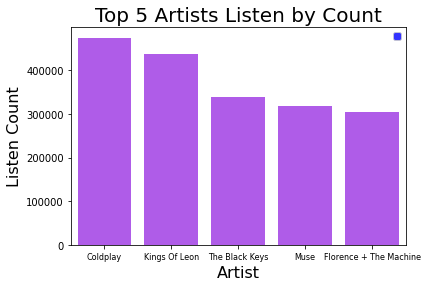

In [ ]:
x = sns.barplot(data=merged_df2, x='artist', y='listen_count', color ='#b445ff')
plt.xlabel('Artist', fontsize=16,);
plt.ylabel('Listen Count', fontsize=16);
plt.title('Top 5 Artists Listen by Count', fontsize=20)
plt.tick_params(axis='x', which='major', labelsize=8)

legend = x.legend()
frame = legend.get_frame()
frame.set_facecolor('blue')

In [ ]:
#artists that appear the most(Most frquently listened to)

merged_df3 = merge_df.groupby(['artist']).size().reset_index()
merged_df3.columns = ['artist', 'count']
merged_df3.sort_values(by = 'count', ascending = False, inplace= True)
merged_df3.head()

,artist,count
1979,Coldplay,140440
5131,Kings Of Leon,100617
8990,The Black Keys,96369
6530,Muse,89449
4278,Jack Johnson,81052


In [ ]:
#graph distribution of listens for above users^

In [ ]:
#artist with most songs
#not sure about this - may be counting duplicates of the same song(want unique songs)

merged_df4 = merge_df['artist'].value_counts()
merged_df4.head()

Coldplay          140440
Kings Of Leon     100617
The Black Keys     96369
Muse               89449
Jack Johnson       81052
Name: artist, dtype: int64

In [ ]:
#user with most listens (how many?)

merged_df5 = merge_df.groupby('user_id')['listen_count'].sum().reset_index()
merged_df5.columns = ['user_id', 'listen_count_sum']
merged_df5.sort_values(by = 'listen_count_sum', ascending = False, inplace = True)
merged_df5.head()

,user_id,listen_count_sum
3574,3574,12827
6841,6841,9175
25152,25153,8443
64479,64481,7094
15866,15866,5370


In [ ]:
#least popular song of most popular artist

top_artists = ['Kings Of Leon', 'Coldplay', 'The Black Keys', 'Muse', 'Florence + The Machine']
merged_df6 = merge_df.groupby(['artist', 'name'])['listen_count'].sum().reset_index()
merged_df6.sort_values(by = 'listen_count', ascending = False, inplace = True)
rslt_df = merged_df6[merged_df6['artist'].isin(top_artists)]
rslt_df = rslt_df.groupby('artist').min()
rslt_df.head()

,name,listen_count
artist,,
Coldplay,1.36,170
Florence + The Machine,Are You Hurting The One You Love?,945
Kings Of Leon,Arizona,357
Muse,Agitated [Live From Le Zenith],220
The Black Keys,10 A.M. Automatic,488


In [ ]:
#songs with most unique listeners
#not sure abt this

merge_df['user_id'].nunique()
merged_df7 = merge_df.groupby(['artist','name', 'user_id'])['listen_count'].sum().reset_index().groupby(['name', 'artist']).size().reset_index()
merged_df7.columns = ['artist','name', 'unique_listener_count']
merged_df7.sort_values(by = 'unique_listener_count', ascending = False, inplace= True)
merged_df7.head()

,artist,name,unique_listener_count
27322,Sehr kosmisch,Harmonia,18949
8044,Dog Days Are Over (Radio Edit),Florence + The Machine,17930
27266,Secrets,OneRepublic,15394
26015,Revelry,Kings Of Leon,15214
34884,Undo,Björk,14916


## Loading Data

In [ ]:
# Load maps from JSON
with open(path.join(BASE_PATH, "song_id_map.json")) as f:
  songIdMap = json.load(f)

with open(path.join(BASE_PATH, "user_id_map.json")) as f:
  userIdMap = json.load(f)

with open(path.join(BASE_PATH, "song_info_map.json")) as f:
  songInfoMap = json.load(f)

In [ ]:
m, n = len(userIdMap), len(songIdMap)

In [ ]:
# Load listen counts
ratings = np.zeros((m,n), dtype=np.uint8)

with open(path.join(BASE_PATH, "train_triplets.csv")) as f:
  reader = csv.reader(f)
  next(reader)

  for userId, songId, listenCount in reader:
    userId, songId, listenCount = int(userId), int(songId), int(listenCount)

    # Clamp listen count to 255 b/c that is maximum 8-bit value
    listenCount = min(listenCount, 255)
    ratings[userId][songId] = listenCount

## Similarity Functions

In [ ]:
def cosine_similarity(a, b):
  magA = np.linalg.norm(a)
  magB = np.linalg.norm(b)

  if magA == 0 or magB == 0:
    return 0
  else:
    return a.dot(b) / (magA * magB)

In [ ]:
def euclidean_similarity(a, b):
  return 1 / (1 + np.linalg.norm(a - b))

In [ ]:
def pearson_correlation(a, b):
  aBar = np.mean(a)
  bBar = np.mean(b)

  return cosine_similarity(a-aBar, b-bBar)

## Collaborative Filtering

In [ ]:
lastSimilarities = None

In [ ]:
# User-based
def collaborative_filtering(data, userRatings, similarityFunction=euclidean_similarity, N=50, new=True):
  global lastSimilarities
  userCount, songCount = len(data), len(data[0])

  assert N <= userCount, 'the value of "N" cannot exceed the number of users'

  userSongIds = [songId for songId,listenCount in userRatings]
  userListenCounts = [listenCount for songId,listenCount in userRatings]

  filteredData = data[:,userSongIds]

  if new:
    similarities = np.array([
        similarityFunction(filteredData[userId], userListenCounts) \
        for userId in range(userCount)
    ])
    lastSimilarities = similarities
  else:
      similarities = lastSimilarities

  mostSimilarUsers = np.argsort(similarities)[-N:]
  mostSimilarRatings = data[mostSimilarUsers]
  mostSimilarSimilarities = similarities[mostSimilarUsers]

  similaritySum = np.sum(mostSimilarSimilarities)

  newRatings = mostSimilarSimilarities.dot(mostSimilarRatings) / similaritySum
  return newRatings

## Evaluation

In [ ]:
def mean_squared_error(target, actual):
    assert len(target) == len(actual), 'cannot compare two vectors with unequal size'
    n = len(target)

    return np.sum(np.square(target-actual)) / n

In [ ]:
# Create "evaluation" version of collaborative filtering algorithm
# Takes in optional similarities to avoid expensive recomputation
def collaborative_filtering_evaluation(data, userRatings, similarityFunction=euclidean_similarity, N=50, lastSimilarities=None):
  userCount, songCount = len(data), len(data[0])

  assert N <= userCount, 'the value of "N" cannot exceed the number of users'

  userSongIds = [songId for songId,listenCount in userRatings]
  userListenCounts = [listenCount for songId,listenCount in userRatings]

  filteredData = data[:,userSongIds]

  if lastSimilarities is None:
    similarities = np.array([
        similarityFunction(filteredData[userId], userListenCounts) \
        for userId in range(userCount)
    ])
  else:
      similarities = lastSimilarities

  mostSimilarUsers = np.argsort(similarities)[-N:]
  mostSimilarRatings = data[mostSimilarUsers]
  mostSimilarSimilarities = similarities[mostSimilarUsers]

  similaritySum = np.sum(mostSimilarSimilarities)

  newRatings = mostSimilarSimilarities.dot(mostSimilarRatings) / similaritySum
  return newRatings, similarities

## Results

In [ ]:
# Select 10 test users randomly
np.random.shuffle(ratings)
trainRatings = ratings[:-10]
testRatings = ratings[-10:]

In [ ]:
# Values of N and similarity functions to evaluate
rangeN = range(1, 500, 10)
similarityFunctions = [euclidean_similarity, cosine_similarity, pearson_correlation]

In [ ]:
totalErrors = [[0]*len(rangeN) for _ in range(len(similarityFunctions))]

# Compute total error over 10 test users for each similarity function
for j,similarityFunction in enumerate(similarityFunctions):
    print(f'Testing similarity function "{similarityFunction.__name__}"...')

    for i,userRatings in enumerate(testRatings):
        print(f'Computing user {i+1}...')

        favoriteSongs = np.argsort(userRatings)[-5:]
        convertedUserRatings = np.array([(songId, userRatings[songId]) for songId in favoriteSongs])
        lastSimilarities = None

        for i,N in enumerate(rangeN):
            predictedUserRatings, lastSimilarities = collaborative_filtering_evaluation(trainRatings, convertedUserRatings,
                similarityFunction=similarityFunction, N=N, lastSimilarities=lastSimilarities)
            totalErrors[j][i] += mean_squared_error(predictedUserRatings, userRatings)

    print()

Testing similarity function "euclidean_similarity"...
Computing user 1...
Computing user 2...
Computing user 3...
Computing user 4...
Computing user 5...
Computing user 6...
Computing user 7...
Computing user 8...
Computing user 9...
Computing user 10...

Testing similarity function "cosine_similarity"...
Computing user 1...
Computing user 2...
Computing user 3...
Computing user 4...
Computing user 5...
Computing user 6...
Computing user 7...
Computing user 8...
Computing user 9...
Computing user 10...

Testing similarity function "pearson_correlation"...
Computing user 1...
Computing user 2...
Computing user 3...
Computing user 4...
Computing user 5...
Computing user 6...
Computing user 7...
Computing user 8...
Computing user 9...
Computing user 10...



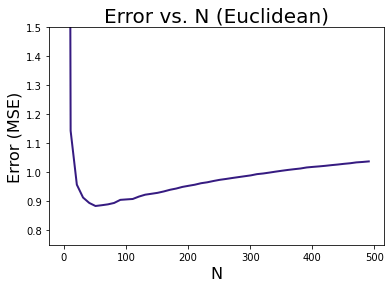

In [ ]:
plt.title('Error vs. N (Euclidean)', fontsize=20)
plt.ylabel('Error (MSE)', fontsize=16)
plt.ylim(.75, 1.5)
plt.xlabel('N', fontsize=16)
plt.plot(rangeN, totalErrors[0], linewidth='2', color='#361b81')
plt.show()

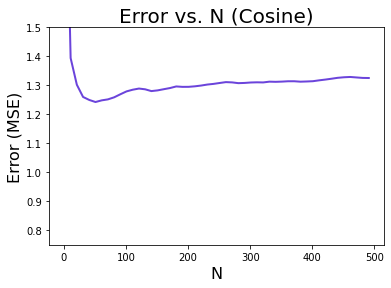

In [ ]:
plt.title('Error vs. N (Cosine)', fontsize=20)
plt.ylabel('Error (MSE)', fontsize=16)
plt.ylim(.75, 1.5)
plt.xlabel('N', fontsize=16)
plt.plot(rangeN, totalErrors[1], linewidth='2', color='#6b44db')
plt.show()

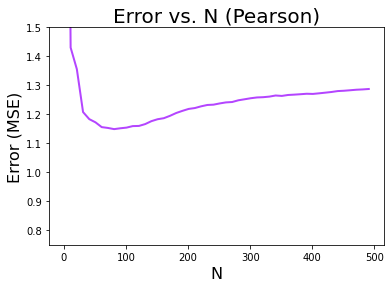

In [ ]:
plt.title('Error vs. N (Pearson)', fontsize=20)
plt.ylabel('Error (MSE)', fontsize=16)
plt.ylim(.75, 1.5)
plt.xlabel('N', fontsize=16)
plt.plot(rangeN, totalErrors[2], linewidth='2', color='#b445ff')
plt.show()

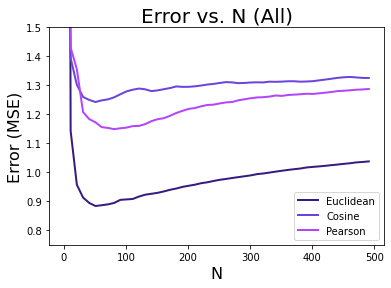

In [ ]:
plt.title('Error vs. N (All)', fontsize=20)
plt.ylabel('Error (MSE)', fontsize=16)
plt.ylim(.75, 1.5)
plt.xlabel('N', fontsize=16)
plt.plot(rangeN, totalErrors[0], label='Euclidean', linewidth='2', color='#361b81')
plt.plot(rangeN, totalErrors[1], label='Cosine', linewidth='2', color='#6b44db')
plt.plot(rangeN, totalErrors[2], label='Pearson', linewidth='2', color='#b445ff')
plt.legend()
plt.show()

In [ ]:
# Find best N value
minIndex = np.argmin(totalErrors[0])
rangeN[minIndex]

51

In [ ]:
def print_songs(songIds):
    for songId in songIds:
        artist, name = songInfoMap[str(songId)]
        print(songId, ':', name, '-', artist)

In [ ]:
# User ratings is a "song id"-"listen count" tuple
# For these examples, the user has listened to each song ten times

In [ ]:
# Create test user who loves Aerosmith
userRatings = [(33110, 10), (33915, 10), (671, 10), (3243, 10), (12401, 10)]
favoriteSongs = [songId for songId,_ in userRatings]

print('Favorite songs:')
print_songs(favoriteSongs)

Favorite songs:
33110 : Walk On Water - Aerosmith
33915 : Dream On - Aerosmith
671 : Round And Round - Aerosmith
3243 : Walk This Way - Aerosmith
12401 : Dude (Looks Like A Lady) - Aerosmith


In [ ]:
predictedUserRatings = collaborative_filtering(ratings, userRatings)
bestPredictedSongs = reversed([songId for songId in np.argsort(predictedUserRatings) if songId not in favoriteSongs][-5:])

print('Recommended songs:')
print_songs(bestPredictedSongs)

Recommended songs:
12089 : Crazy - Aerosmith
34292 : It's My Life - Bon Jovi
25725 : Abololo - Marisa Monte
2443 : Sincerité Et Jalousie - Alliance Ethnik
12172 : Over The Hills And Far Away - Nightwish


In [ ]:
# Create test user who likes concertos
userRatings = [(6686, 10), (16795, 10), (9505, 10), (22955, 10), (27290, 10)]
favoriteSongs = [songId for songId,_ in userRatings]

print('Favorite songs:')
print_songs(favoriteSongs)

Favorite songs:
6686 : Horn Concerto No. 2 in E flat K417 (2008 Digital Remaster): I.   Allegro maestoso - Dennis Brain/Philharmonia Orchestra/Walter Susskind
16795 : Concerto No. 2 in B-Flat Major for Piano and Orchestra_ Op. 83: IV. Allegretto grazioso - Berlin Symphony Orchestra
9505 : Keyboard Concerto in G minor BWV1058: I.   [Allegro] - Andrei Gavrilov/Academy of St Martin-in-the-Fields/Sir Neville Marriner/John Constable
22955 : Concerto for guitar & small orchestra: Third movement: Allegretto non troppo - Angel Romero/London Philharmonic Orchestra/Jésus López-Cobos
27290 : Triple Concerto - William Orbit


In [ ]:
predictedUserRatings = collaborative_filtering(ratings, userRatings)
bestPredictedSongs = reversed([songId for songId in np.argsort(predictedUserRatings) if songId not in favoriteSongs][-5:])

print('Recommended songs:')
print_songs(bestPredictedSongs)

Recommended songs:
3279 : Apology - Alesana
30301 : Montego Bay - The Bar-Kays
33915 : Dream On - Aerosmith
27485 : No Damn Fool - Throttlerod
19794 : Serenity in fire - KATAKLYSM


In [ ]:
# Create test user who listens to rap music
userRatings = [(29107, 10), (18766, 10), (24856, 10), (7517, 10), (3852, 10)]
favoriteSongs = [songId for songId,_ in userRatings]

print('Favorite songs:')
print_songs(favoriteSongs)

Favorite songs:
29107 : RoboCop - Kanye West
18766 : Evil Deeds - Eminem
24856 : Family Business - Kanye West
7517 : Got Money - Lil Wayne / T-Pain
3852 : Coldest Winter - Kanye West


In [ ]:
predictedUserRatings = collaborative_filtering(ratings, userRatings)
bestPredictedSongs = reversed([songId for songId in np.argsort(predictedUserRatings) if songId not in favoriteSongs][-5:])

print('Recommended songs:')
print_songs(bestPredictedSongs)

Recommended songs:
30846 : Gears - Future Rock
36216 : Say You Will - Kanye West
14655 : Street Lights - Kanye West
2968 : Stronger - Kanye West
19162 : Champion - Kanye West


## Conclusion
The recommendations generated by our algorithm for the rock user and rap user were good, but the recommendations for the classical user could have been improved. This was likely due to the lack of classical music in the dataset. Our method of downsampling was to simply take the most popular songs. However, we suspect that this led to a significant reduction in the amount of classical music, as pop and hip-hop music tends to have the greatest listen counts. To improve this project, we should either attempt to downsample the data in a way that is less biased, or we should attempt to use more of the original data by compressing the representation. This could be done using techniques from linear algebra, such as matrix factorization.

## References

- http://millionsongdataset.com/tasteprofile
- http://millionsongdataset.com/sites/default/files/AdditionalFiles/unique_tracks.txt
- https://towardsdatascience.com/intro-to-recommender-system-collaborative-filtering-64a238194a26
- https://realpython.com/build-recommendation-engine-collaborative-filtering